# Connecting to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


# Importing necessary libraries

In [ ]:
from pathlib import Path  # Importing Path from pathlib for working with file path
import numpy as np  # Importing NumPy for numerical operations
import pandas as pd  # Importing Pandas for data manipulation
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting
import seaborn as sns  # Importing Seaborn for statistical visualization
import os  # Operating System dependent functionality
import cv2  # OpenCV library for computer vision tasks
from tqdm import tqdm  # tqdm is used to show progress bars for loops
import tensorflow as tf  # Importing TensorFlow for deep learning tasks
from tensorflow.keras.models import Sequential  # Sequential model for stacking layers
from tensorflow.keras.applications import DenseNet201  # Pre-trained DenseNet201 model
from tensorflow.keras.layers import Dense, Dropout, AveragePooling2D, Flatten  # Different layers for building models
from tensorflow.keras.losses import BinaryCrossentropy  # Loss function for binary classification
from tensorflow.keras.optimizers import Adam  # Optimizer for model training
from keras.preprocessing.image import load_img, img_to_array # For image preprocessing
from tensorflow.keras.utils import plot_model  # Utility function for plotting model architecture
from sklearn.utils import shuffle  # Utility function for shuffling data
from sklearn.model_selection import train_test_split  # Function for splitting data into train and test sets
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc  # Functions for evaluating model performance

In [ ]:
# Define the directory containing the image data
data_dir = Path('./Dataset')
# Count the number of image files in the directory
image_count = len(list(data_dir.glob('*/*.png')))
# Print the total number of image files found
print(image_count)

3264


# Defining image properties

In [ ]:
img_height = 224  # Height of the input images
img_width = 224  # Width of the input images
img_size = (img_height, img_width)  # Size of the input images
n_channels = 3  # Number of color channels (RGB)

# Data Loading and Pre-Processing

In [ ]:
def load_data(data_dir, class_names, image_size):
    """
    Load image data from the specified directory.

    Parameters:
        data_dir (Path): The path to the directory containing the image data.
        class_names (list): A list of class names.
        image_size (tuple): A tuple specifying the desired image size (height, width).

    Returns:
        tuple: A tuple containing two NumPy arrays: images and labels.
               - images: An array containing the loaded images.
               - labels: An array containing the corresponding labels.

    Example:
        data_dir = Path('./Dataset')
        class_names = ['Healthy', 'Parkinson']
        image_size = (64, 64)
        images, labels = load_data(data_dir, class_names, image_size)
    """
    # Initialize empty lists to store images and labels
    images = []
    labels = []
    # Define label mapping for class names
    label_map = {class_name: i for i, class_name in enumerate(class_names)}
    # Iterate through folders in the data directory
    for folder in class_names:
        folder_path = data_dir / folder
        label = label_map[folder]
        # Iterate through each image in the folder
        for file in tqdm(os.listdir(folder_path)):
            # Get the path of each image
            img_path = folder_path / file
            # Open and resize the image
            image = cv2.imread(str(img_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, image_size)
            # Append the image and its corresponding label to the output lists
            images.append(image)
            labels.append(label)
    # Convert lists to NumPy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')

    return images, labels

In [ ]:
class_names = ['Healthy', 'Parkinson']
# Call the load_data function to load the image data
images, labels = load_data(data_dir, class_names, img_size)

100%|██████████| 1632/1632 [00:31<00:00, 51.77it/s]


In [ ]:
# Shuffle the images and labels with a specified random state for reproducibility
images, labels = shuffle(images, labels, random_state=10)

# Split the shuffled data into training and testing sets
# The test_size parameter specifies the proportion of the dataset to include in the test split (here, 20%)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2,  stratify=labels)

# Data Exploration and Visualization

In [ ]:
# Get the number of training and testing examples by accessing the shape of the label arrays
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

# Print the number of training and testing examples
print("Number of training examples: {}".format(n_train))
print("Number of testing examples: {}".format(n_test))

# Print the shapes of the training and testing image and label arrays
print("Training images are of shape: {}".format(train_images.shape))
print("Training labels are of shape: {}".format(train_labels.shape))
print("Test images are of shape: {}".format(test_images.shape))
print("Test labels are of shape: {}".format(test_labels.shape))

Number of training examples: 2611
Number of testing examples: 653
Training images are of shape: (2611, 224, 224, 3)
Training labels are of shape: (2611,)
Test images are of shape: (653, 224, 224, 3)
Test labels are of shape: (653,)


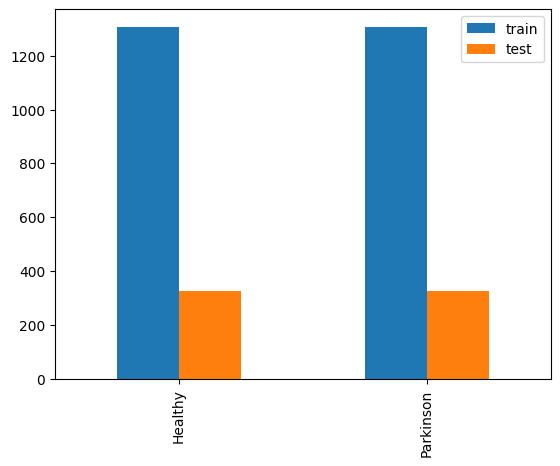

In [ ]:
# Count the occurrences of each unique label in the training set
# and store the counts in train_counts
_, train_counts = np.unique(train_labels, return_counts=True)

# Count the occurrences of each unique label in the test set
# and store the counts in test_counts
_, test_counts = np.unique(test_labels, return_counts=True)

# Create a DataFrame to visualize the counts of each class in both training and test sets
# with class names as the index
pd.DataFrame({'train': train_counts,  "test": test_counts}, index=class_names).plot.bar()

# Display the bar plot
plt.show()

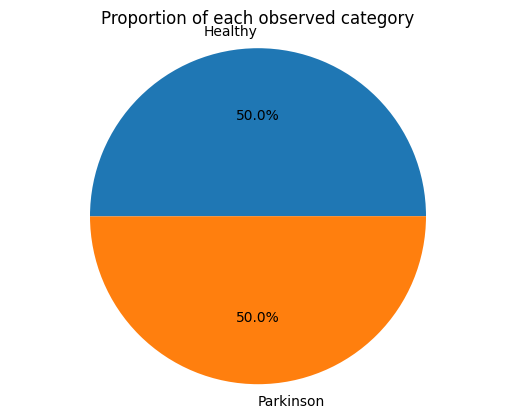

In [ ]:
# Create a pie chart to visualize the proportions of each class in the training set
plt.pie(train_counts,
        explode=(0, 0),  # Parameter to explode slices, if needed (not used here)
        labels=class_names,  # Labels for each slice
        autopct='%1.1f%%')  # Format for displaying percentages on the slices
# Set the aspect ratio to be equal, making the pie circular
plt.axis('equal')
# Set the title of the plot
plt.title('Proportion of each observed category')
# Display the pie chart
plt.show()

In [ ]:
# Scale pixel values of the training images to the range [0, 1]
train_images = train_images / 255.0

# Scale pixel values of the test images to the range [0, 1]
test_images = test_images / 255.0

In [ ]:
def display_random_image(class_names, images, labels):
    """
    Display a randomly selected image along with its label.

    Parameters:
    - class_names (list): List of class names corresponding to the labels.
    - images (array): Array of image data.
    - labels (array): Array of corresponding labels.

    Returns:
    None
    """
    # Generate a random index within the range of the number of images
    index = np.random.randint(images.shape[0])
    # Create a new figure for the image
    plt.figure()
    # Display the image corresponding to the randomly selected index
    plt.imshow(images[index])
    # Remove ticks on both axes
    plt.xticks([])
    plt.yticks([])
    # Disable grid lines
    plt.grid(False)
    # Set the title of the image using the class name corresponding to the label
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    # Show the image
    plt.show()

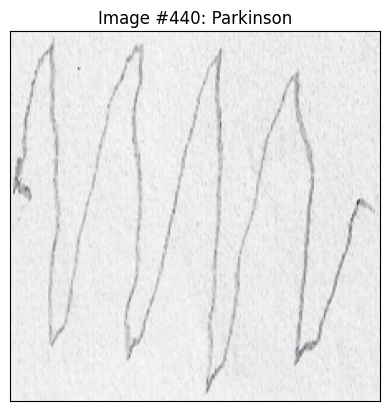

In [ ]:
# Call the function to display a random image from the training set
display_random_image (class_names, train_images, train_labels)

In [ ]:
def display_examples(class_names, images, labels):
    """
    Display examples of images along with their corresponding labels.

    Parameters:
    - class_names (list): List of class names corresponding to the labels.
    - images (array): Array of image data.
    - labels (array): Array of corresponding labels.

    Returns:
    None
    """
    # Create a new figure with a specified size and title
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    # Iterate over the first 25 images in the dataset
    for i in range(25):
        # Create a subplot within the figure
        plt.subplot(5, 5, i+1)
        # Remove ticks on both axes
        plt.xticks([])
        plt.yticks([])
        # Disable grid lines
        plt.grid(False)
        # Display the image with a grayscale colormap
        plt.imshow(images[i], cmap=plt.cm.binary)
        # Set the label of the image using the corresponding class name
        plt.xlabel(class_names[labels[i]], fontsize=10)
    # Show the figure containing the images
    plt.show()


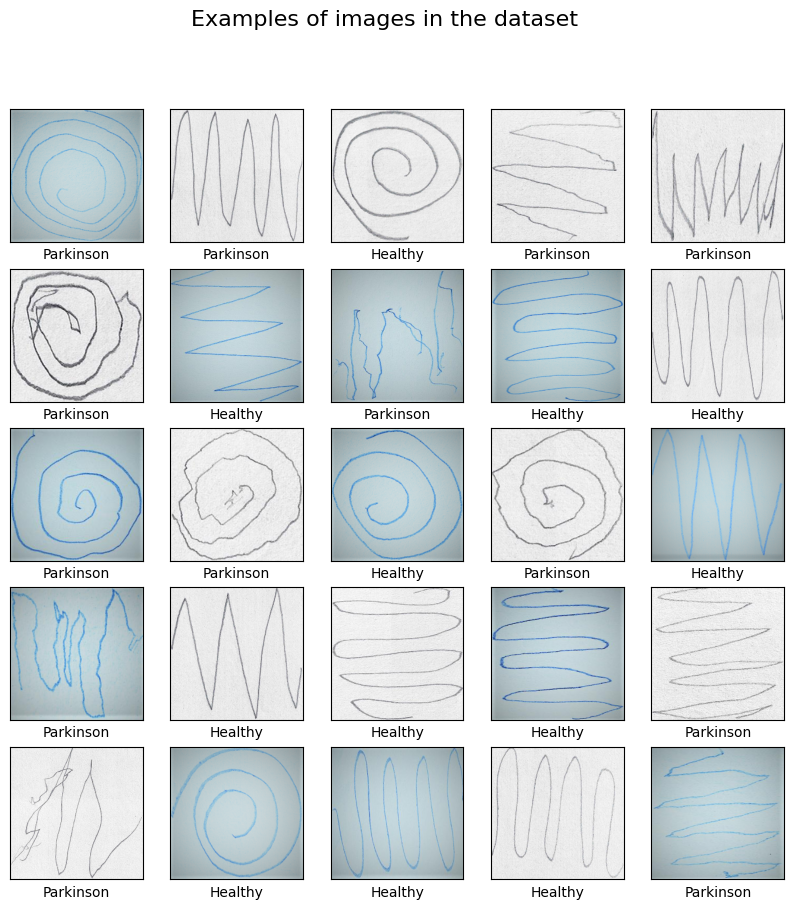

In [ ]:
# Call the function to display examples of images from the training set
display_examples(class_names, train_images, train_labels)

# Defining the CNN Architecture

In [ ]:
# Load the pre-trained DenseNet201 model as the base model
base_densenet_model = Sequential([
    DenseNet201(input_shape=(img_height, img_width, n_channels), include_top=False, weights="imagenet"),
], name="base_densenet_model")

# Freeze the layers of the base model to prevent their weights from being updated during training
base_densenet_model.trainable = False

# Display summary of the base model
base_densenet_model.summary()

# Adding a densely connected classifier on top of the DenseNet201 convolutional base
custom_densenet_model = Sequential([
    base_densenet_model,  # Use the frozen base model as the first layer
    AveragePooling2D(pool_size=7),  # Apply average pooling to reduce spatial dimensions
    Flatten(),  # Flatten the feature maps
    Dropout(rate=0.5),  # Apply dropout regularization to prevent overfitting
    Dense(units=512, activation="relu"),  # Add a dense layer with ReLU activation
    Dense(units=1, activation="sigmoid", name="output_layer"),  # Add the output layer for binary classification
], name="custom_densenet_model")

# Display summary of the custom model
custom_densenet_model.summary()

Model: "base_densenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
Total params: 18321984 (69.89 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 18321984 (69.89 MB)
_________________________________________________________________
Model: "custom_densenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_densenet_model (Seque  (None, 7, 7, 1920)        18321984  
 ntial)                                                          
                                                                 
 average_pooling2d (Average  (None, 1, 1, 1920)        0         
 Pooling2D)                                                      
                                        

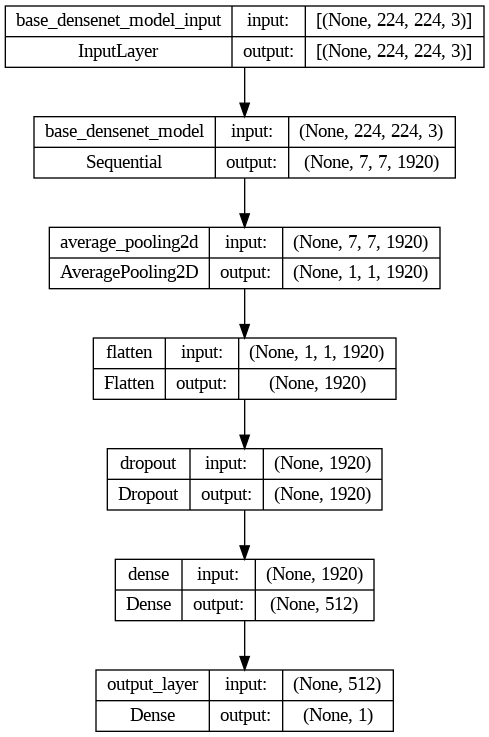

In [ ]:
# Plot the architecture of the custom_densenet_model and save it to 'model_plot.png'
plot_model(custom_densenet_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Configuring the model for training

In [ ]:
learning_rate = 0.001
# Compile the custom DenseNet201 model with specified optimizer, loss function, and evaluation metrics
custom_densenet_model.compile(
    optimizer=Adam(learning_rate=learning_rate),  # Adam optimizer with specified learning rate
    loss=BinaryCrossentropy(from_logits=False),  # Binary cross-entropy loss function
    metrics=['accuracy']  # Accuracy metric for evaluation
)

# Training the model

In [ ]:
batch_size = 44
epochs = 100
# Train the custom DenseNet201 model on the training data
history = custom_densenet_model.fit(
    train_images,  # Training images
    train_labels,  # Training labels
    batch_size=batch_size,  # Batch size
    epochs=epochs,  # Number of epochs
    validation_data=(test_images, test_labels),  # Validation data
    verbose=1
)

Epoch 1/100
60/60 [==============================] - 53s 520ms/step - loss: 0.5102 - accuracy: 0.7541 - val_loss: 0.4007 - val_accuracy: 0.8040
Epoch 2/100
60/60 [==============================] - 14s 233ms/step - loss: 0.3849 - accuracy: 0.8288 - val_loss: 0.3161 - val_accuracy: 0.8560
Epoch 3/100
60/60 [==============================] - 14s 235ms/step - loss: 0.3660 - accuracy: 0.8407 - val_loss: 0.2880 - val_accuracy: 0.8652
Epoch 4/100
60/60 [==============================] - 14s 236ms/step - loss: 0.3439 - accuracy: 0.8487 - val_loss: 0.2943 - val_accuracy: 0.8576
Epoch 5/100
60/60 [==============================] - 14s 237ms/step - loss: 0.3408 - accuracy: 0.8437 - val_loss: 0.2502 - val_accuracy: 0.9051
Epoch 6/100
60/60 [==============================] - 14s 239ms/step - loss: 0.3289 - accuracy: 0.8571 - val_loss: 0.2407 - val_accuracy: 0.8974
Epoch 7/100
60/60 [==============================] - 14s 241ms/step - loss: 0.3011 - accuracy: 0.8728 - val_loss: 0.2379 - val_accuracy:

# Saving the model

In [ ]:
# Saving the model with h5 extension
custom_densenet_model.save('custom_densenet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluating the results

In [ ]:
test_loss, test_acc = custom_densenet_model.evaluate(test_images, test_labels)

# Print the test loss and accuracy of the model
print('Loss of the model is:', test_loss)
print('Accuracy of the model is:' , test_acc * 100, "%")

21/21 [==============================] - 15s 397ms/step - loss: 0.0300 - accuracy: 0.9954
Loss of the model is: 0.029964245855808258
Accuracy of the model is: 99.54057931900024 %


## Plot the loss and accuracy curves

In [ ]:
def plot_loss_accuracy(history):
    """
    Plots training and validation accuracy and loss curves over epochs.

    Parameters:
    - history: A History object returned by the fit method of a Keras model.

    Returns:
    - None
    """
    # Extract accuracy and loss values from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # Number of epochs
    epochs = range(1, len(acc) + 1)

    # Plotting accuracy and loss curves
    plt.figure(figsize=(15, 6))

    # Plotting accuracy curves
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.legend()

    # Plotting loss curves
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend()

    plt.show()


##

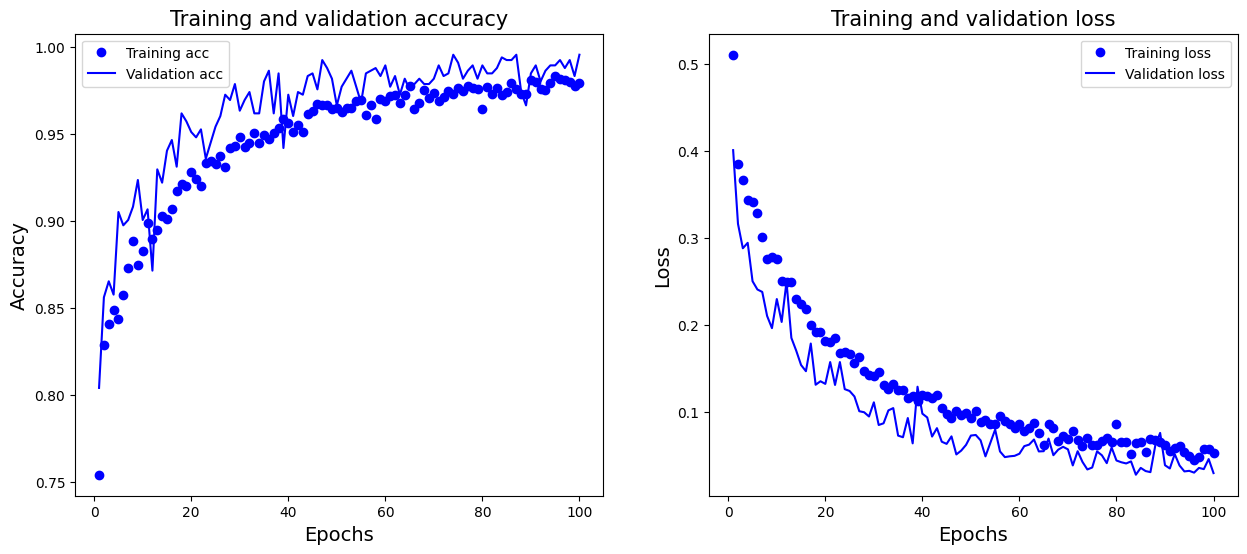

In [ ]:
# Call the function to plot the curves
plot_loss_accuracy(history)

 ## Generate the classification report

In [ ]:
# Generate predictions using the custom DenseNet201 model
predictions = custom_densenet_model.predict(test_images)
# Set the threshold for binary classification
threshold = 0.5
# Apply the threshold to obtain binary predictions
predicted_labels = (predictions >= threshold).astype(int)
# Generate a classification report
target_names = ['Healthy', 'Parkinson']
report = classification_report(test_labels, predicted_labels, target_names=target_names, digits=4)

# Print the classification report
print(report)

21/21 [==============================] - 6s 150ms/step
              precision    recall  f1-score   support

     Healthy     0.9939    0.9969    0.9954       326
   Parkinson     0.9969    0.9939    0.9954       327

    accuracy                         0.9954       653
   macro avg     0.9954    0.9954    0.9954       653
weighted avg     0.9954    0.9954    0.9954       653



## Plot the confusion matrix

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Plot the confusion matrix.

    Parameters:
        cm (array): Confusion matrix array.
        class_names (list): List of class names.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                cmap='Blues',
                linecolor='black',
                linewidth=1,
                annot=True,
                fmt='',
                xticklabels=class_names,
                yticklabels=class_names)

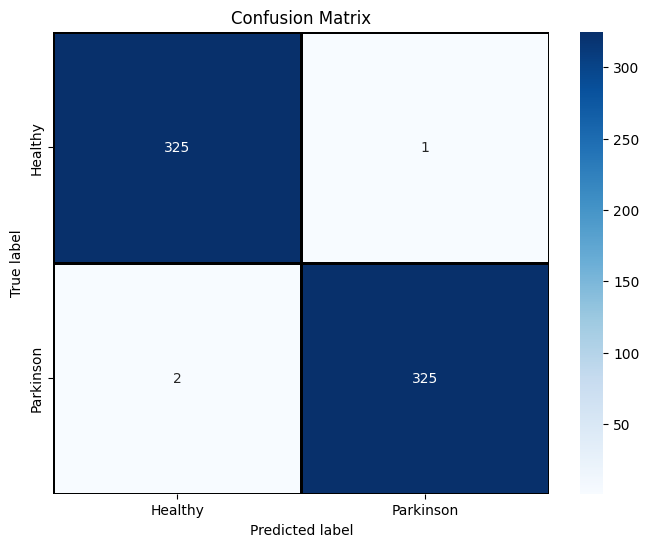

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

## Plot the ROC curve

In [ ]:
def plot_roc(test_labels, predicted_labels):
    """
    Plot the Receiver Operating Characteristic (ROC) curve.

    Parameters:
        test_labels (array-like): True labels of the test data.
        predicted_labels (array-like): Predicted probabilities or scores for the test data.

    Returns:
        None
    """
    # Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)
    fpr, tpr, _ = roc_curve(test_labels, predicted_labels)
    # Calculate the Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2  # Line width
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='darkturquoise', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    # Plot the diagonal line representing random guessing
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # Set x-axis limits
    plt.xlim([0.0, 1.0])
    # Set y-axis limits
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

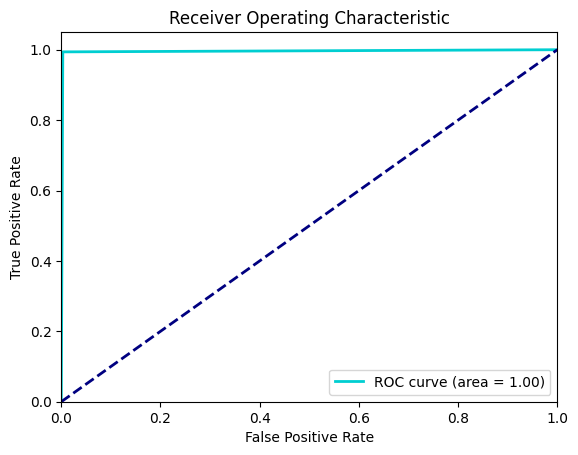

In [ ]:
# Call the plot_roc function
plot_roc(test_labels, predicted_labels)

# Prediction on unseen image data

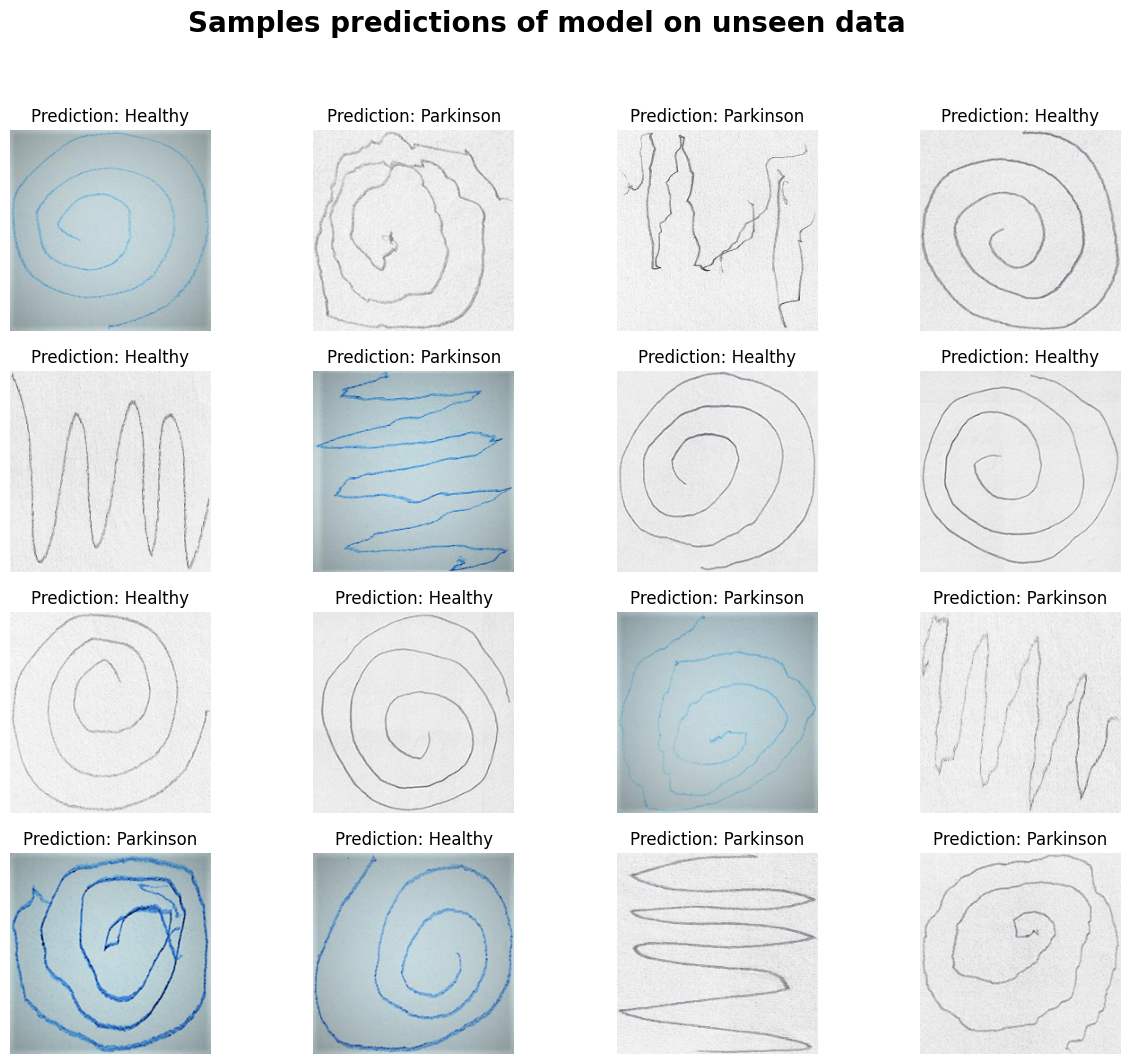

In [ ]:
# Define a dictionary mapping class indices to class labels
class_mapping = {0: 'Healthy', 1: 'Parkinson'}

# Plot the images along with their predicted labels
plt.figure(figsize=(15, 12))
# Enumerate through a randomly selected subset of test images
for n, i in enumerate(np.random.randint(len(test_images), size=16)):
    plt.subplot(4,4, n+1)
    plt.imshow(test_images[i])  # Display the image
    plt.title(f"Prediction: {class_mapping[predicted_labels[i].item()]}") # Set title using predicted label from dictionary
    plt.axis('off')  # Turn off axis
    plt.suptitle("Samples predictions of model on unseen data", size=20, weight='bold')

plt.show()  # Show the plot

In [ ]:
def predict_image(img_path, model):
    """
    Predict the label of an image using a given model
    Parameters:
        img_path (str): The file path of the image to be predicted.
        model (keras.Model): The trained Keras model used for prediction.

    Returns:
        None
    """
    # Load the image from the given path and resize it to the target size
    img = load_img(img_path, target_size=(224, 224))
    # Convert the image to an array
    img_tensor = img_to_array(img)
    # Expand the dimensions to match the expected input shape of the model
    img_tensor = np.expand_dims(img_tensor, axis=0)
    # Normalize the image pixel values
    img_tensor /= 255.
    # Make predictions using the provided model
    prediction = model.predict(img_tensor)
    # Retrieve the predicted probability of the positive class
    predicted_pro = prediction[0]
    # Define a dictionary mapping class indices to class labels
    class_mapping = {0: 'Healthy', 1: 'Parkinson'}
    # Define the threshold for binary classification
    threshold = 0.5
    # Determine the predicted class based on the threshold
    if predicted_pro >= threshold:
        predicted_class = 1
    else:
        predicted_class = 0
    # Retrieve the predicted label based on the predicted class
    predicted_label = class_mapping[predicted_class]

    # Display the image with the predicted label as the title
    plt.title("Result: {}".format(str(predicted_label).title()), size=18, color='red')
    plt.imshow(img)


1/1 [==============================] - 3s 3s/step


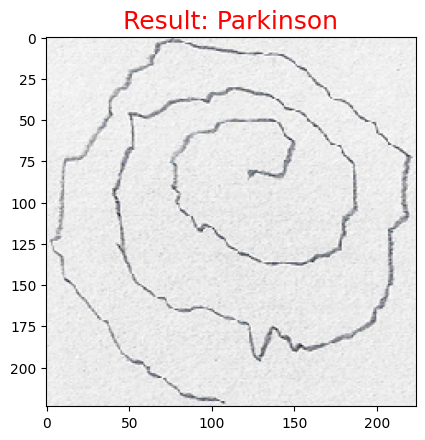

In [ ]:
img_path = './Dataset/Parkinson/Parkinson1036.png'
predict_image(img_path, custom_densenet_model)